In [60]:
import pandas as pd
import torch
import shap
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [57]:
# Load the dataset
file_path = "./NY_gasoline_data.csv"  # Replace with the actual file path
gasoline_data = pd.read_csv(file_path)
gasoline_data.head()


,Date,New York State Average ($/gal),Albany Average ($/gal),Batavia Average ($/gal),Binghamton Average ($/gal),Buffalo Average ($/gal),Dutchess Average ($/gal),Elmira Average ($/gal),Glens Falls Average ($/gal),Ithaca Average ($/gal),...,Glens Falls Average ($/gal)Diesel,Ithaca Average ($/gal)Diesel,Kingston Average ($/gal)Diesel,Nassau Average ($/gal)Diesel,New York City Average ($/gal)Diesel,Rochester Average ($/gal)Diesel,Syracuse Average ($/gal)Diesel,Utica Average ($/gal)Diesel,Watertown Average ($/gal)Diesel,White Plains Average ($/gal)Diesel
0,1/2/17,2.52,2.44,NaN,2.50,2.44,2.56,2.47,2.47,2.48,...,2.66,2.73,2.69,2.76,2.90,2.64,2.67,2.69,2.69,2.81
1,1/9/17,2.54,2.46,NaN,2.51,2.46,2.57,2.47,2.47,2.49,...,2.67,2.74,2.71,2.78,2.92,2.65,2.67,2.70,2.71,2.83
2,1/16/17,2.54,2.45,2.45,2.50,2.47,2.58,2.47,2.45,2.49,...,2.67,2.74,2.70,2.79,2.93,2.66,2.68,2.70,2.72,2.84
3,1/23/17,2.53,2.43,2.44,2.48,2.47,2.56,2.44,2.43,2.48,...,2.67,2.73,2.69,2.78,2.93,2.65,2.67,2.68,2.72,2.83
4,1/30/17,2.51,2.40,2.43,2.46,2.46,2.54,2.41,2.39,2.46,...,2.66,2.72,2.67,2.77,2.93,2.64,2.65,2.66,2.70,2.83


/var/folders/gv/0bb9p9810zqdhslznc7lff680000gn/T/ipykernel_10395/1092122372.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gasoline_data[col] = gasoline_data[col].fillna(method='ffill').fillna(method='bfill')  # Fill start/end gaps


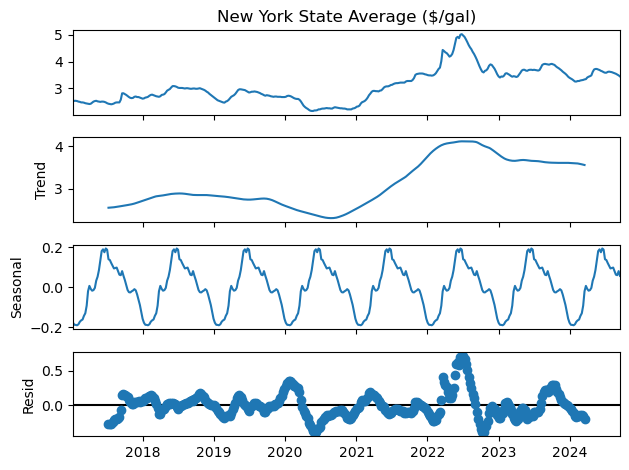

In [58]:
# Parse the date column and set it as the index
gasoline_data['Date'] = pd.to_datetime(gasoline_data['Date'], format='%m/%d/%y')
gasoline_data.set_index('Date', inplace=True)

# Select only numeric columns
numeric_columns = gasoline_data.select_dtypes(include='number').columns
for col in numeric_columns:
    gasoline_data[col] = gasoline_data[col].interpolate(method='linear')  # Fill internal gaps
    gasoline_data[col] = gasoline_data[col].fillna(method='ffill').fillna(method='bfill')  # Fill start/end gaps

monthly_data = gasoline_data.resample('W').mean()


# Initialize dictionaries to store detrended and deseasonalized results
detrended_data = pd.DataFrame(index=monthly_data.index)
deseasonalized_data = pd.DataFrame(index=monthly_data.index)

column_to_analyze = "New York State Average ($/gal)"  # Replace with the column you want
if column_to_analyze in numeric_columns:
    decomposition = seasonal_decompose(monthly_data[column_to_analyze], model='additive', period=52)

    # Plot the decomposition
    decomposition.plot()
    #plt.suptitle(f"Seasonal Decomposition of {column_to_analyze}")#, fontsize=16)
    plt.show()
else:
    print(f"Column '{column_to_analyze}' not found in numeric columns.")

# Perform detrending and seasonal decomposition
for col in numeric_columns:
    try:
        # Handle missing values by interpolating (can also use other imputation methods)
        monthly_data[col] = monthly_data[col].interpolate(method='linear')

        # Apply a 12-week moving average for detrending (approx. quarterly smoothing)
        detrended_data[col] = monthly_data[col] - monthly_data[col].rolling(window=12, center=True).mean()

        # Seasonal decomposition to isolate and remove seasonal components
        decomposition = seasonal_decompose(monthly_data[col], model='additive', period=52)
        deseasonalized_data[col] = monthly_data[col] - decomposition.seasonal
    except Exception as e:
        print(f"Error processing column {col}: {e}")

# Save results
detrended_data.to_csv("detrended_gasoline_prices_weekly.csv")
deseasonalized_data.to_csv("deseasonalized_gasoline_prices_weekly.csv")


In [24]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Load the original dataset
file_path = "NY_gasoline_data.csv"  # Replace with your file path
gasoline_data = pd.read_csv(file_path)

# Parse the date column and set it as the index
gasoline_data['Date'] = pd.to_datetime(gasoline_data['Date'], format='%m/%d/%y')
gasoline_data.set_index('Date', inplace=True)

# Select numeric columns and fill missing values
numeric_columns = gasoline_data.select_dtypes(include='number').columns
for col in numeric_columns:
    gasoline_data[col] = gasoline_data[col].interpolate(method='linear')  # Fill internal gaps
    gasoline_data[col] = gasoline_data[col].fillna(method='ffill').fillna(method='bfill')  # Fill start/end gaps

# Resample the data to weekly frequency
gasoline_data = gasoline_data.resample('W').mean()

# Detrend and deseasonalize each numeric column
detrended_deseasonalized_data = pd.DataFrame(index=gasoline_data.index)

for column in numeric_columns:
    try:
        # Decompose the resampled data
        decomposition = seasonal_decompose(gasoline_data[column], model='additive', period=52)
        # Extract the residual (detrended and deseasonalized data)
        residual = decomposition.resid
        print(residual)
        detrended_deseasonalized_data[column] = residual

    except Exception as e:
        print(f"Error processing column {column}: {e}")

# Drop NaN values (from seasonal decomposition edges)
detrended_deseasonalized_data.dropna(inplace=True)

# Save the detrended and deseasonalized data
detrended_deseasonalized_data.to_csv("detrended_deseasonalized_gasoline_prices_weekly.csv")



/var/folders/gv/0bb9p9810zqdhslznc7lff680000gn/T/ipykernel_12717/2549041487.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gasoline_data[col] = gasoline_data[col].fillna(method='ffill').fillna(method='bfill')  # Fill start/end gaps


Date
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
2017-02-05   NaN
              ..
2024-08-18   NaN
2024-08-25   NaN
2024-09-01   NaN
2024-09-08   NaN
2024-09-15   NaN
Freq: W-SUN, Name: resid, Length: 402, dtype: float64
Date
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
2017-02-05   NaN
              ..
2024-08-18   NaN
2024-08-25   NaN
2024-09-01   NaN
2024-09-08   NaN
2024-09-15   NaN
Freq: W-SUN, Name: resid, Length: 402, dtype: float64
Date
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
2017-02-05   NaN
              ..
2024-08-18   NaN
2024-08-25   NaN
2024-09-01   NaN
2024-09-08   NaN
2024-09-15   NaN
Freq: W-SUN, Name: resid, Length: 402, dtype: float64
Date
2017-01-08   NaN
2017-01-15   NaN
2017-01-22   NaN
2017-01-29   NaN
2017-02-05   NaN
              ..
2024-08-18   NaN
2024-08-25   NaN
2024-09-01   NaN
2024-09-08   NaN
2024-09-15   NaN
Freq: W-SUN, Name: resid, Length: 402, dtype: float64
Date
2017-01-08 

In [25]:
detrended_deseasonalized_data

,New York State Average ($/gal),Albany Average ($/gal),Batavia Average ($/gal),Binghamton Average ($/gal),Buffalo Average ($/gal),Dutchess Average ($/gal),Elmira Average ($/gal),Glens Falls Average ($/gal),Ithaca Average ($/gal),Kingston Average ($/gal),...,Glens Falls Average ($/gal)Diesel,Ithaca Average ($/gal)Diesel,Kingston Average ($/gal)Diesel,Nassau Average ($/gal)Diesel,New York City Average ($/gal)Diesel,Rochester Average ($/gal)Diesel,Syracuse Average ($/gal)Diesel,Utica Average ($/gal)Diesel,Watertown Average ($/gal)Diesel,White Plains Average ($/gal)Diesel
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-09,-0.261485,-0.279344,-0.221662,-0.239652,-0.275840,-0.237880,-0.296463,-0.269302,-0.246867,-0.277466,...,-0.181950,-0.197149,-0.185968,-0.185019,-0.160679,-0.192944,-0.217331,-0.200294,-0.235895,-0.167404
2017-07-16,-0.269919,-0.286116,-0.234574,-0.267509,-0.286169,-0.243608,-0.320034,-0.276760,-0.253530,-0.281174,...,-0.177939,-0.191064,-0.185213,-0.176640,-0.147946,-0.197354,-0.199515,-0.213934,-0.231472,-0.163984
2017-07-23,-0.267227,-0.290622,-0.233489,-0.261589,-0.277873,-0.245078,-0.309004,-0.286376,-0.265109,-0.268303,...,-0.166977,-0.176297,-0.159855,-0.156365,-0.133028,-0.195966,-0.195917,-0.198796,-0.232626,-0.138489
2017-07-30,-0.246430,-0.262806,-0.218393,-0.252083,-0.268367,-0.225504,-0.300446,-0.264961,-0.251606,-0.244732,...,-0.141538,-0.160006,-0.136984,-0.137025,-0.111599,-0.184290,-0.177551,-0.184552,-0.210456,-0.128297
2017-08-06,-0.216567,-0.227407,-0.198159,-0.213814,-0.247914,-0.203966,-0.240391,-0.215922,-0.228969,-0.202397,...,-0.115494,-0.141737,-0.101229,-0.101626,-0.087918,-0.157999,-0.147331,-0.156983,-0.184783,-0.113214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18,-0.149480,-0.167998,-0.126854,-0.162495,-0.097529,-0.163196,-0.214553,-0.184178,-0.222307,-0.187136,...,-0.053337,-0.104470,0.012947,0.018607,0.027714,0.016190,-0.002895,0.008951,-0.013066,0.005453
2024-02-25,-0.141114,-0.128891,-0.136566,-0.169212,-0.117090,-0.138238,-0.204086,-0.155497,-0.221977,-0.154430,...,-0.030260,0.036477,0.029348,0.036629,0.027879,0.013787,0.004138,0.013607,-0.015841,0.007335
2024-03-03,-0.136760,-0.113850,-0.162266,-0.192701,-0.140716,-0.135875,-0.178605,-0.146403,-0.223942,-0.150172,...,-0.009010,0.034032,0.050323,0.038923,0.036175,0.002976,-0.000793,0.027344,-0.013917,0.034437


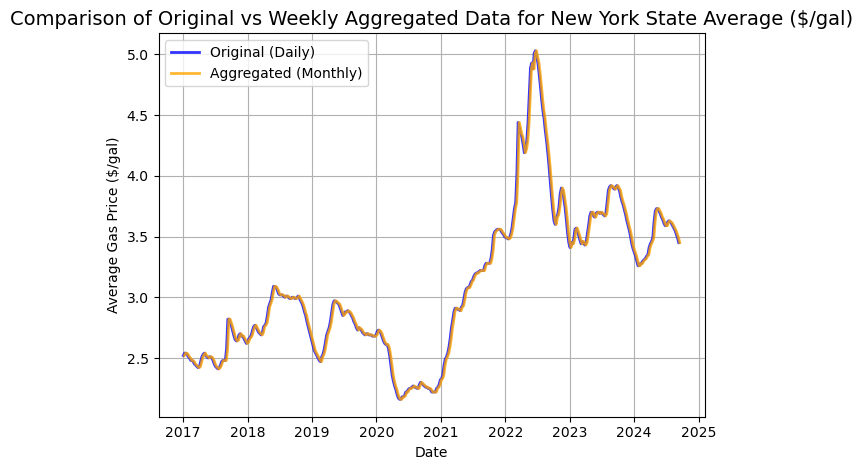

In [59]:
column_to_plot = "New York State Average ($/gal)" 
# Plot original data
plt.plot(
    gasoline_data[column_to_plot],
    label="Original (Daily)",
    alpha=0.8,
    linewidth=2,
    color="blue",
)

# Plot aggregated weekly data
plt.plot(
    monthly_data[column_to_plot],
    label="Aggregated (Monthly)",
    alpha=0.8,
    linewidth=2,
    color="orange",
)

# Add labels, legend, and title
plt.title(f"Comparison of Original vs Weekly Aggregated Data for {column_to_plot}", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Average Gas Price ($/gal)")
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

Epoch 1/100, Loss: 2.3436
Epoch 2/100, Loss: 1.4754
Epoch 3/100, Loss: 0.8151
Epoch 4/100, Loss: 0.5054
Epoch 5/100, Loss: 0.3488
Epoch 6/100, Loss: 0.3013
Epoch 7/100, Loss: 0.2731
Epoch 8/100, Loss: 0.2476
Epoch 9/100, Loss: 0.2314
Epoch 10/100, Loss: 0.2265
Epoch 11/100, Loss: 0.2196
Epoch 12/100, Loss: 0.2129
Epoch 13/100, Loss: 0.2079
Epoch 14/100, Loss: 0.2021
Epoch 15/100, Loss: 0.1955
Epoch 16/100, Loss: 0.1887
Epoch 17/100, Loss: 0.1814
Epoch 18/100, Loss: 0.1743
Epoch 19/100, Loss: 0.1678
Epoch 20/100, Loss: 0.1617
Epoch 21/100, Loss: 0.1560
Epoch 22/100, Loss: 0.1508
Epoch 23/100, Loss: 0.1456
Epoch 24/100, Loss: 0.1411
Epoch 25/100, Loss: 0.1375
Epoch 26/100, Loss: 0.1339
Epoch 27/100, Loss: 0.1312
Epoch 28/100, Loss: 0.1289
Epoch 29/100, Loss: 0.1271
Epoch 30/100, Loss: 0.1254
Epoch 31/100, Loss: 0.1234
Epoch 32/100, Loss: 0.1213
Epoch 33/100, Loss: 0.1194
Epoch 34/100, Loss: 0.1177
Epoch 35/100, Loss: 0.1156
Epoch 36/100, Loss: 0.1141
Epoch 37/100, Loss: 0.1127
Epoch 38/1

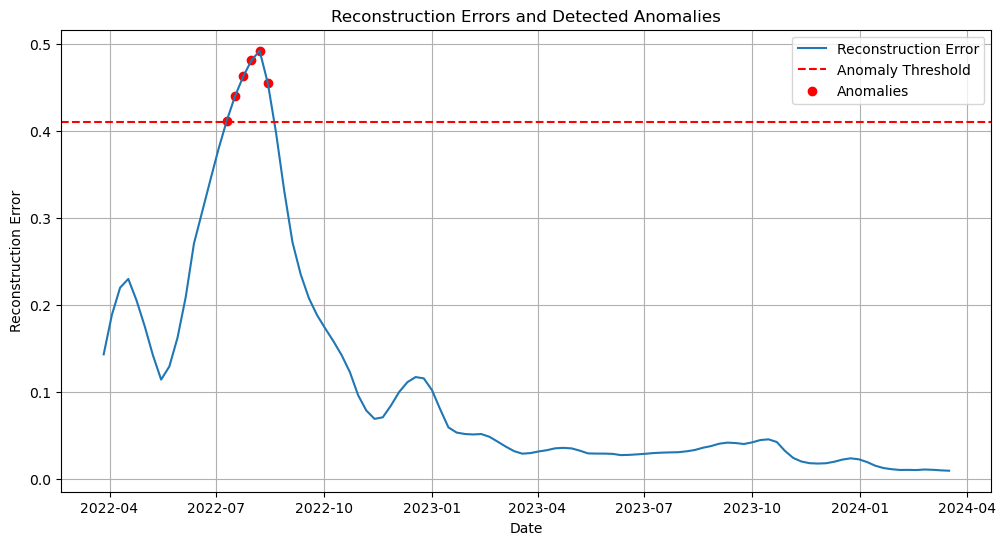

In [113]:
from sklearn.preprocessing import MinMaxScaler
from utils import create_sequences
from autoencoder import LSTMAutoencoder
import torch.nn as nn
import numpy as np

# Load the data
file_path = "detrended_deseasonalized_gasoline_prices_weekly.csv"  # Replace with your file path
gasoline_data = pd.read_csv(file_path)

# Parse the date column and set it as the index
gasoline_data['Date'] = pd.to_datetime(gasoline_data['Date'])
gasoline_data.set_index('Date', inplace=True)
numeric_columns = gasoline_data.select_dtypes(include='number').columns

# target_col = "New York State Average ($/gal)"
data = gasoline_data[numeric_columns].copy()

# Split data into training (up to 2023) and testing (2024)
train_data = data[data.index.year <= 2021]
test_data = data[data.index.year > 2021]

# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

sequence_length = 12  # 12 weeks of data (or adjust based on context)
train_sequences = create_sequences(train_scaled, sequence_length)
test_sequences = create_sequences(test_scaled, sequence_length)

input_dim = len(numeric_columns)  # Single feature (New York State Average)
hidden_dim = 64  # Number of hidden units in LSTM
model = LSTMAutoencoder(input_dim, hidden_dim, sequence_length)

# Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training the Model
num_epochs = 100
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_sequences, batch_size=batch_size, shuffle=False)

model.train()
train_history = []
val_history = []
for epoch in range(num_epochs):
    epoch_loss = 0
    temp_train = []
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        temp_train.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_history.append(np.mean(temp_train))
    
    with torch.no_grad():
        temp = []
        for batch in test_loader:
            output = model(batch)
            val_loss = nn.MSELoss(reduction='mean')(output, batch)
            temp.append(val_loss.detach().numpy())
        val_history.append(np.mean(temp))

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluate on Test Data
model.eval()

reconstruction_errors = []

with torch.no_grad():
    for batch in test_loader:
        output = model(batch)
        loss = nn.MSELoss(reduction='none')(output, batch)
        reconstruction_errors.extend(loss.mean(dim=(1, 2)).numpy())

# Detect Anomalies
threshold = np.percentile(reconstruction_errors, 95)  # Define threshold for anomalies
anomalies = [i for i, error in enumerate(reconstruction_errors) if error > threshold]

# Visualize Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], reconstruction_errors, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.scatter(
    test_data.index[sequence_length:][anomalies],
    np.array(reconstruction_errors)[anomalies],
    color='red',
    label="Anomalies"
)
plt.title("Reconstruction Errors and Detected Anomalies")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid()
plt.show()


[]

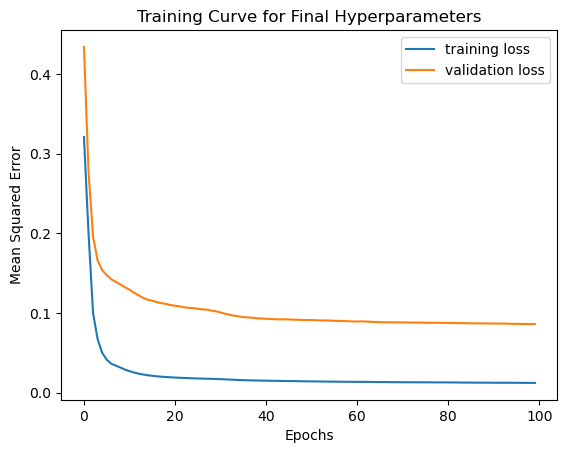

In [109]:
plt.plot(train_history, label='training loss')
plt.plot(val_history, label='validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.title("Training Curve for Final Hyperparameters")
plt.plot()

/var/folders/gv/0bb9p9810zqdhslznc7lff680000gn/T/ipykernel_12717/3494636606.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  original_test_data[anomalies],


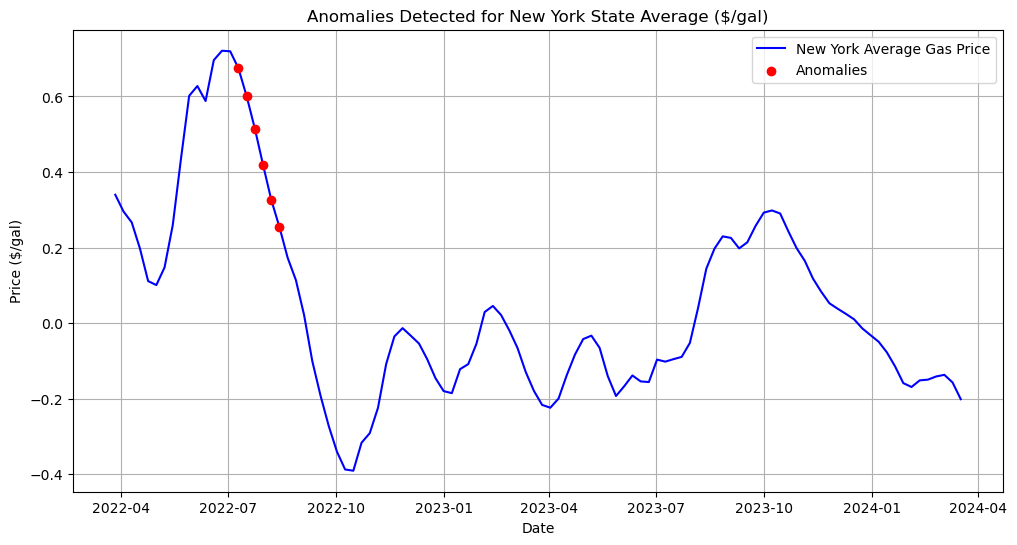

In [114]:
column_to_plot = "New York State Average ($/gal)"  # Replace with your column of interest
test_dates = gasoline_data.index[train_scaled.shape[0] + sequence_length:]  # Align dates with test set
original_test_data = data.iloc[train_scaled.shape[0] + sequence_length:][column_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, original_test_data, label="New York Average Gas Price", color="blue")
plt.scatter(
    test_dates[anomalies],
    original_test_data[anomalies],
    color="red",
    label="Anomalies",
    zorder=5,
)
plt.title(f"Anomalies Detected for {column_to_plot}")
plt.xlabel("Date")
plt.ylabel("Price ($/gal)")
plt.legend()
plt.grid()
plt.show()

In [80]:
import itertools
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np

# Prepare the data
sequence_length = 12
data_scaled = scaler.fit_transform(data)  # Normalize data
sequences = create_sequences(data_scaled, sequence_length)
sequences = torch.tensor(sequences, dtype=torch.float32)

# Define hyperparameter search space
param_grid = {
    'hidden_dim': [16, 32, 64],  # Number of hidden units in LSTM
    'learning_rate': [0.001, 0.0005],  # Learning rates
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_val = np.inf

# Loop through all hyperparameter combinations
for params in param_combinations:
    hidden_dim, learning_rate = params
    print(f"Testing params: hidden_dim={hidden_dim}, lr={learning_rate}")
    

    val_score = []
    for train_index, val_index in kf.split(sequences):
        # Split data into training and validation sets
        train_data, val_data = sequences[train_index], sequences[val_index]
        
        # Initialize the model
        input_dim = train_data.shape[2]
        model = LSTMAutoencoder(input_dim, hidden_dim, sequence_length)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # Train the model
        model.train()
        for epoch in range(30):  # Reduce epochs for faster tuning
            optimizer.zero_grad()
            outputs = model(train_data)
            loss = criterion(outputs, train_data)
            loss.backward()
            optimizer.step()
        
        # Evaluate reconstruction error on validation set
        model.eval()
        with torch.no_grad():
            val_reconstruction = model(val_data)
            reconstruction_loss = nn.MSELoss(reduction='none')(val_reconstruction, val_data)
            val_scores = reconstruction_loss.mean(dim=(1, 2)).numpy()
        
        
        val_score.append(np.mean(val_scores))
    
    min_val = np.mean(val_score)
    print(min_val)
    
    # Update best parameters if current AUC is better
    if min_val < best_val:
        best_val = min_val
        best_params = params

# Print the best hyperparameters and corresponding AUC
print(f"Best Parameters: {best_params}")
print(f"Best val MSE: {best_val}")



/var/folders/gv/0bb9p9810zqdhslznc7lff680000gn/T/ipykernel_12717/3805457587.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences = torch.tensor(sequences, dtype=torch.float32)


Testing params: hidden_dim=16, lr=0.001
0.083777
Testing params: hidden_dim=16, lr=0.0005
0.15425786
Testing params: hidden_dim=32, lr=0.001
0.049735237
Testing params: hidden_dim=32, lr=0.0005
0.10804993
Testing params: hidden_dim=64, lr=0.001
0.034345478
Testing params: hidden_dim=64, lr=0.0005
0.058761813
Best Parameters: (64, 0.001)
Best val MSE: 0.03434547781944275


Anomaly scores for test data: [-0.21947513 -0.19855918 -0.2100161  -0.20749244 -0.22710624 -0.2232493
 -0.21911306 -0.14159352 -0.17125805 -0.13556802 -0.15022314 -0.11046491
 -0.16602999 -0.18810859 -0.20135444 -0.20355079 -0.21162544 -0.22272701
 -0.23941119 -0.16192569 -0.10128929 -0.14431681 -0.14315421 -0.15342159
 -0.16220544 -0.19046304 -0.21187292 -0.21299471 -0.21914898 -0.19617362
 -0.22021853 -0.21754838 -0.22163395 -0.15690645 -0.2153862  -0.20364116
 -0.20590363 -0.20558473 -0.2069336  -0.17685196 -0.17933541 -0.19791845
 -0.20590273 -0.1972603  -0.17911767 -0.16057562 -0.0649355  -0.08842711
 -0.0786317  -0.05069344 -0.05915131 -0.05961046 -0.05623823 -0.06714981
 -0.06503336 -0.02622963 -0.04781952 -0.04404367 -0.05435611 -0.04184519
 -0.07768218 -0.06815649 -0.06521849  0.00250531 -0.03642518 -0.02934344
 -0.05396977 -0.07796627 -0.10358713 -0.09016608 -0.07673864 -0.05020814
 -0.00381745 -0.00570932 -0.00651003  0.00319752  0.00555255  0.0041726
 -0.00427746 -0.0093283

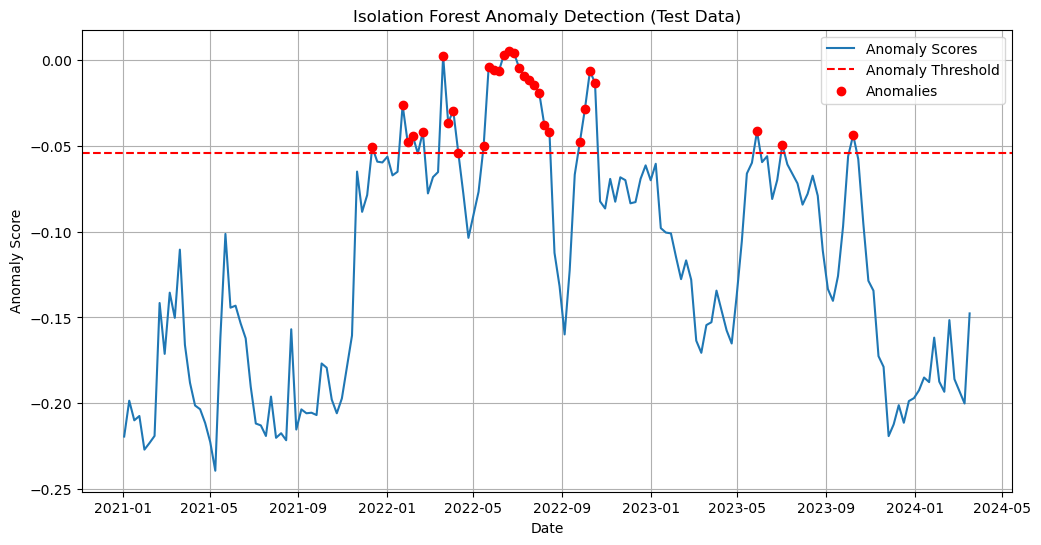

In [168]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import shap


file_path = "detrended_deseasonalized_gasoline_prices_weekly.csv"  # Replace with your actual file path
gasoline_data = pd.read_csv(file_path)

# Parse the date column and set it as the index
gasoline_data['Date'] = pd.to_datetime(gasoline_data['Date'])
gasoline_data.set_index('Date', inplace=True)

# Select numeric columns
numeric_columns = gasoline_data.select_dtypes(include='number').columns
data = gasoline_data[numeric_columns].copy()

# Split data into training (up to 2023) and testing (2024)
train_data = data[data.index.year <= 2020]
test_data = data[data.index.year > 2020]

train_data_array = train_data.values
test_data_array = test_data.values

# # Fit Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)  # Adjust contamination level as needed
iso_forest.fit(train_data_array)
# Predict anomaly scores for the test data
iso_scores = -iso_forest.decision_function(test_data_array)  # Negative decision function gives anomaly scores

# Define a threshold for anomalies based on the training set scores (95th percentile)
threshold = np.percentile(-iso_forest.decision_function(train_data_array), 95)

# Identify anomalies in the test data
test_anomalies = iso_scores > threshold

# Evaluate using ground truth (if available)
# If no ground truth, you can use the anomaly scores for qualitative analysis
print("Anomaly scores for test data:", iso_scores)
print("Anomalous test data indices:", np.where(test_anomalies)[0])

# Optionally, plot the anomaly scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, iso_scores, label="Anomaly Scores")
plt.axhline(y=threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.scatter(
    test_data.index[test_anomalies],
    iso_scores[test_anomalies],
    color="red",
    label="Anomalies",
    zorder=5,
)
plt.title("Isolation Forest Anomaly Detection (Test Data)")
plt.xlabel("Date")
plt.ylabel("Anomaly Score")
plt.legend()
plt.grid()
plt.show()


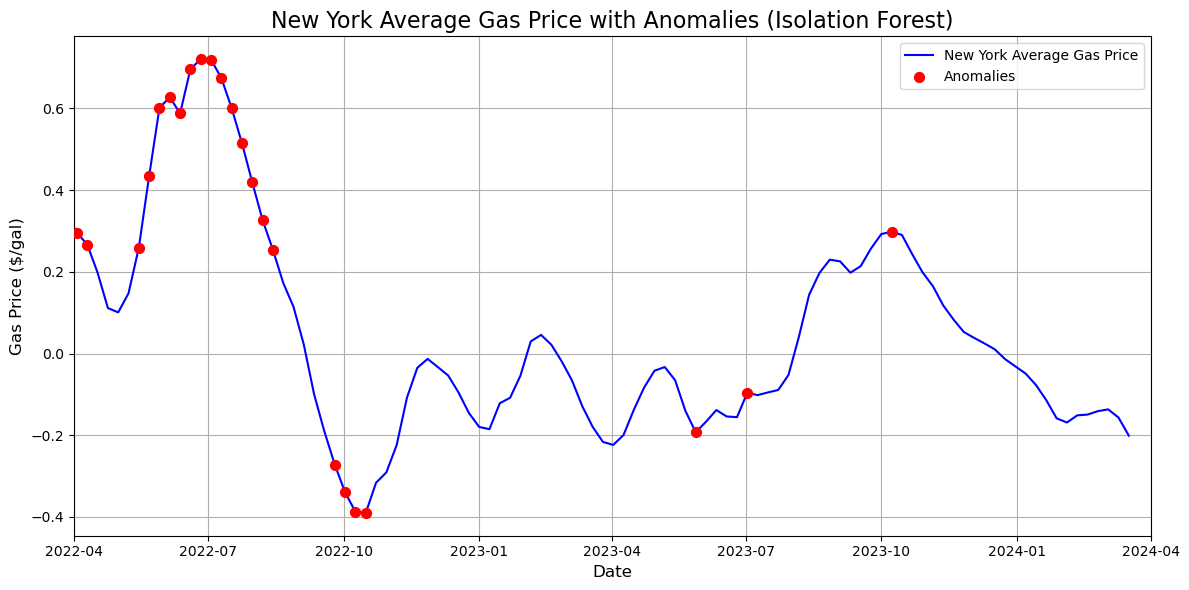

In [169]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `iso_scores` are the anomaly scores from Isolation Forest for the test data
# Assume `test_anomalies` is a boolean array indicating whether each point is an anomaly
# and `test_data` is the subset of the original data for the test period
# Replace "New York State Average ($/gal)" with your actual column name
target_column = "New York State Average ($/gal)"

# Ensure test_data has the corresponding target column
if target_column not in test_data.columns:
    raise ValueError(f"Column '{target_column}' not found in the test data!")

# Get the indices of anomalies
anomaly_indices = np.where(test_anomalies)[0]

# Get the corresponding dates and gas prices for the anomalies
anomaly_dates = test_data.index[anomaly_indices]
anomaly_gas_prices = test_data[target_column].iloc[anomaly_indices]

# Plot gas price
plt.figure(figsize=(12, 6))
plt.plot(
    test_data.index,
    test_data[target_column],
    label="New York Average Gas Price",
    color="blue",
    linewidth=1.5,
)

# Plot anomalies as red points directly on the gas price line
plt.scatter(
    anomaly_dates,
    anomaly_gas_prices,
    color="red",
    label="Anomalies",
    zorder=5,
    marker="o",
    s=50,  # Size of the marker
)

# Add labels, title, and legend
plt.title("New York Average Gas Price with Anomalies (Isolation Forest)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Gas Price ($/gal)", fontsize=12)
plt.xlim('2022-04', '2024-04')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()


/Users/patricksicurello/anaconda3/envs/dl-notes/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


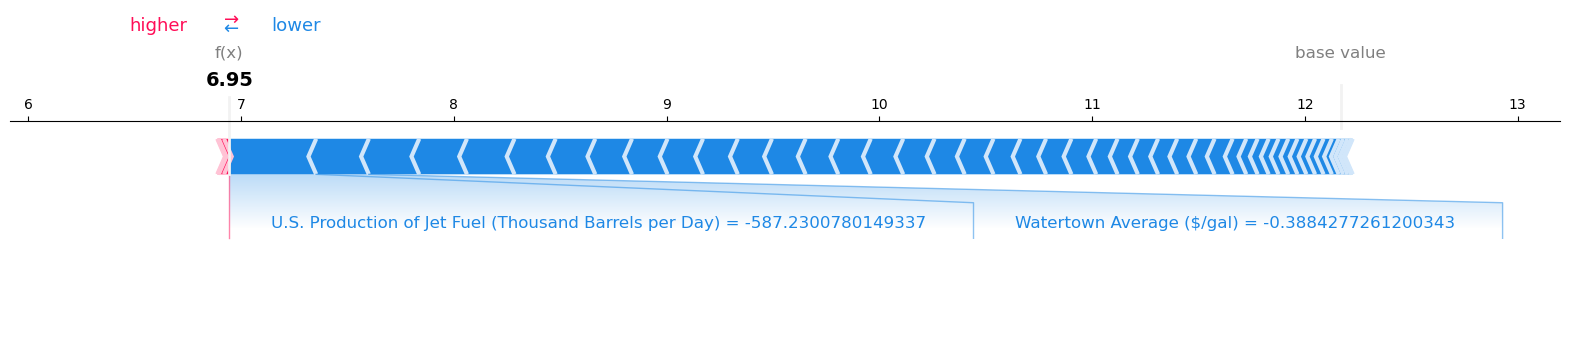

Feature contributions for the first anomaly:
                                              Feature  SHAP Value
24                WTI Crude Oil Spot Price ($/barrel)    0.025610
30     East Coast Jet Fuels Stocks (Thousand Barrels)    0.024494
25              Brent Crude Oil Spot Price ($/barrel)    0.004493
32           U.S. Crude Oil Stocks (Thousand Barrels)    0.002380
23      NY Ultra-Low Sulfur Diesel Spot Price ($/gal)   -0.002630
22        NY Conventional Gasoline Spot Price ($/gal)   -0.004302
27    Mid-Atlantic Gasoline Stocks (Thousand Barrels)   -0.017702
16                       White Plains Average ($/gal)   -0.020266
26  Mid-Atlantic ULS Diesel Stocks (Thousand Barrels)   -0.020790
29      East Coast Ethanol Stocks  (Thousand Barrels)   -0.032102
46                     Syracuse Average ($/gal)Diesel   -0.039137
14                              Utica Average ($/gal)   -0.039695
13                           Syracuse Average ($/gal)   -0.040897
47                        Utica

In [105]:
import shap

explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer.shap_values(data)

# Find anomaly indices (rows where predictions are -1)
anomaly_indices = np.where(iso_forest.predict(data) == -1)[0]

# Ensure we have anomalies to explain
if len(anomaly_indices) > 0:
    # Select the first anomaly for explanation
    anomaly_index = anomaly_indices[0]

    # Visualize the SHAP force plot for the first anomaly
    shap.force_plot(
        explainer.expected_value,
        shap_values[anomaly_index, :],
        data.iloc[anomaly_index, :],
        matplotlib=True,
    )

    # Print feature contributions for the first anomaly
    print("Feature contributions for the first anomaly:")
    print(pd.DataFrame({
        "Feature": data.columns,
        "SHAP Value": shap_values[anomaly_index, :]
    }).sort_values(by="SHAP Value", ascending=False))
else:
    print("No anomalies were detected to explain.")

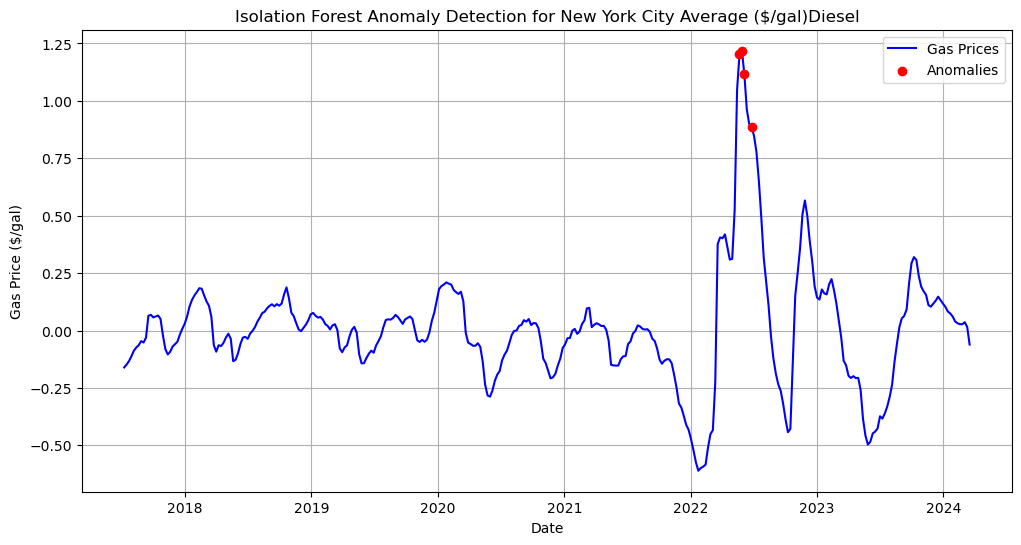

Anomalies detected:
            New York State Average ($/gal)  Albany Average ($/gal)  \
Date                                                                 
2022-05-22                        0.434811                0.433341   
2022-05-29                        0.601558                0.586146   
2022-06-05                        0.627391                0.595184   
2022-06-26                        0.720836                0.678437   

            Batavia Average ($/gal)  Binghamton Average ($/gal)  \
Date                                                              
2022-05-22                 0.370463                    0.427661   
2022-05-29                 0.531312                    0.575225   
2022-06-05                 0.581777                    0.609920   
2022-06-26                 0.629197                    0.689183   

            Buffalo Average ($/gal)  Dutchess Average ($/gal)  \
Date                                                            
2022-05-22                

In [36]:
# Visualize anomalies for a selected feature
feature = "New York City Average ($/gal)Diesel"  # Replace with your target feature
plt.figure(figsize=(12, 6))
plt.plot(gasoline_data.index, gasoline_data[feature], label="Gas Prices", color="blue")
plt.scatter(
    gasoline_data.index[gasoline_data['Anomaly']],
    gasoline_data[feature][gasoline_data['Anomaly']],
    color="red",
    label="Anomalies",
    zorder=5,
)
plt.title(f"Isolation Forest Anomaly Detection for {feature}")
plt.xlabel("Date")
plt.ylabel("Gas Price ($/gal)")
plt.legend()
plt.grid()
plt.show()

# Print anomalies detected
print("Anomalies detected:")
print(gasoline_data[gasoline_data['Anomaly']])

In [156]:
test_anomalies

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [157]:
iso_scores

array([ 0.00836039,  0.00897163,  0.01228279,  0.0491382 ,  0.02032777,
        0.02457762,  0.02012416,  0.01781169, -0.00868815, -0.01936868,
       -0.09162866,  0.02510851, -0.02211536,  0.00751016, -0.03031125,
       -0.07572198, -0.10598583, -0.0962902 , -0.06183878, -0.03570697,
        0.01370049,  0.01128245,  0.00189284,  0.0105663 ,  0.02410134,
        0.01483453,  0.00316656, -0.00755501, -0.00162766, -0.00981632,
       -0.00931441, -0.01746069, -0.04111946, -0.10419005, -0.14278814,
       -0.15550033, -0.13520811, -0.09861486, -0.04119076,  0.01573603,
        0.04538927,  0.04753303, -0.06344831, -0.07455631, -0.06221076,
       -0.08618849, -0.05157509, -0.06882526, -0.07603286, -0.06931515,
       -0.06305976, -0.07300632, -0.06975219, -0.05519732, -0.09017605,
       -0.09581827, -0.08647861, -0.10582055, -0.09026323, -0.10609028,
       -0.1036323 , -0.14921962, -0.15712003, -0.16058729, -0.14937098,
       -0.12917027, -0.15352957, -0.17137465, -0.18238573, -0.16

In [115]:
weather_file_path = './monthly_ny_weather_data.csv'
weather_data = pd.read_csv(weather_file_path)
weather_data.head(), weather_data.columns

(       STATION                 DATE REPORT_TYPE  SOURCE  AWND BackupElements  \
 0  72518014735  2015-01-31T23:59:00       SOM         6   8.9         PRECIP   
 1  72518014735  2015-02-28T23:59:00       SOM         6   8.7         PRECIP   
 2  72518014735  2015-03-31T23:59:00       SOM         6   9.4         PRECIP   
 3  72518014735  2015-04-30T23:59:00       SOM         6   9.4         PRECIP   
 4  72518014735  2015-05-31T23:59:00       SOM         6   8.3         PRECIP   
 
    BackupElevation BackupEquipment  BackupLatitude  BackupLongitude  ...  \
 0              260         PLASTIC         42.6918        -73.83109  ...   
 1              260         PLASTIC         42.6918        -73.83109  ...   
 2              260         PLASTIC         42.6918        -73.83109  ...   
 3              260         PLASTIC         42.6918        -73.83109  ...   
 4              260         PLASTIC         42.6918        -73.83109  ...   
 
   MonthlyMeanTemperature  MonthlyMinSeaLevelPre

In [170]:
import seaborn as sns

anomalies_df = pd.DataFrame({
    'DATE': test_data.index,  # Replace with your date array
    'Anomaly_Score': iso_scores,  # Replace with your scores
    'Anomalous': test_anomalies.astype(int)  # 1 for anomaly, 0 for normal
})

# Ensure DATE column is datetime for merging
anomalies_df['DATE'] = pd.to_datetime(anomalies_df['DATE'])

# Filter for April 2022 to October 2022
# weather_filtered = weather_data[(weather_data['DATE'] >= '2022-04-01') & (weather_data['DATE'] <= '2022-10-31')]

# Select relevant variables for analysis
weather_relevant = weather_data[
    ['DATE', 'MonthlyMeanTemperature', 'MonthlyMaximumTemperature',
     'MonthlyMinimumTemperature', 'MonthlyTotalLiquidPrecipitation',
     'MonthlySeaLevelPressure', 'MonthlyStationPressure']
]

weather_relevant = weather_relevant.copy()
anomalies_df['DATE'] = pd.to_datetime(anomalies_df['DATE']).dt.to_period('M').dt.to_timestamp('M')

# Convert weather_relevant DATE to monthly resolution for consistency
weather_relevant['DATE'] = pd.to_datetime(weather_relevant['DATE']).dt.to_period('M').dt.to_timestamp('M')


# Merge the DataFrames
merged_data = pd.merge(weather_relevant, anomalies_df, on="DATE", how="inner")


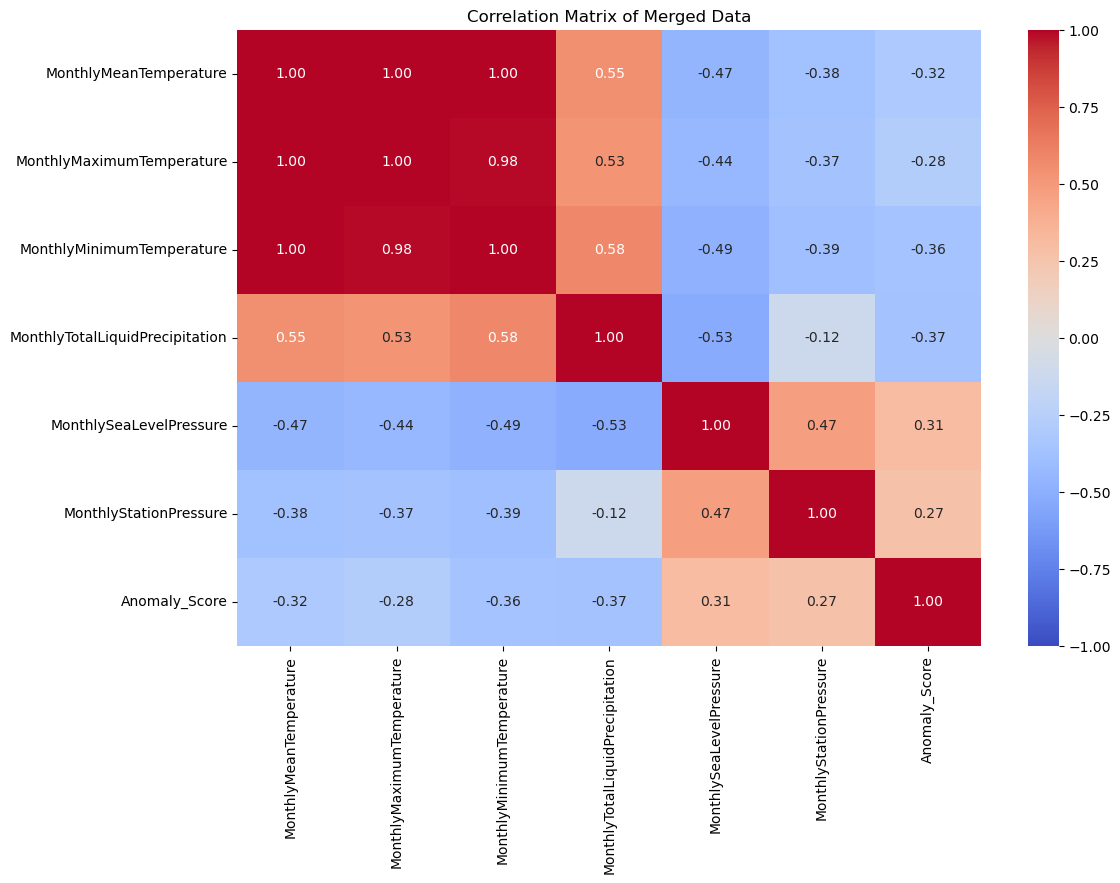

In [177]:
correlation_matrix = merged_data.drop(['DATE', 'Anomalous'], axis=1).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,  
    fmt=".2f", 
    cmap="coolwarm",
    vmin=-1, vmax=1 
)
plt.title("Correlation Matrix of Merged Data")
plt.show()

Variance in MonthlyMeanTemperature: 295.41059
Standard Deviation in MonthlyMeanTemperature: 17.18751
Mean MonthlyMeanTemperature: 46.00588


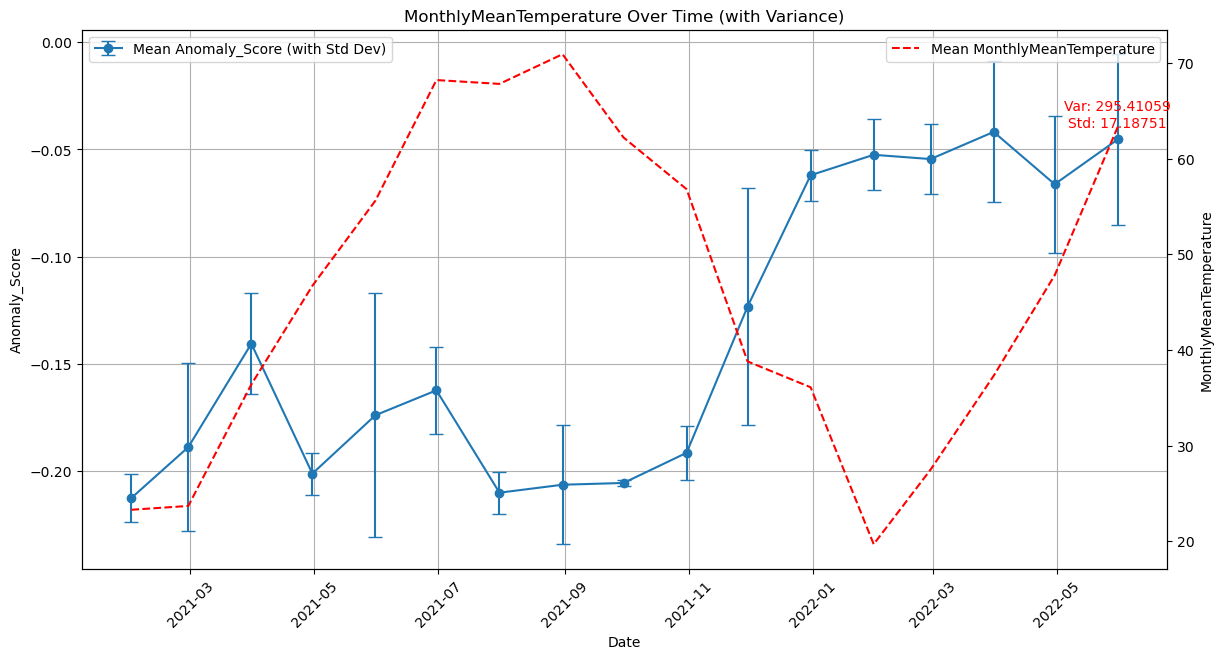

Variance in MonthlySeaLevelPressure: 0.00478
Standard Deviation in MonthlySeaLevelPressure: 0.06917
Mean MonthlySeaLevelPressure: 30.02706


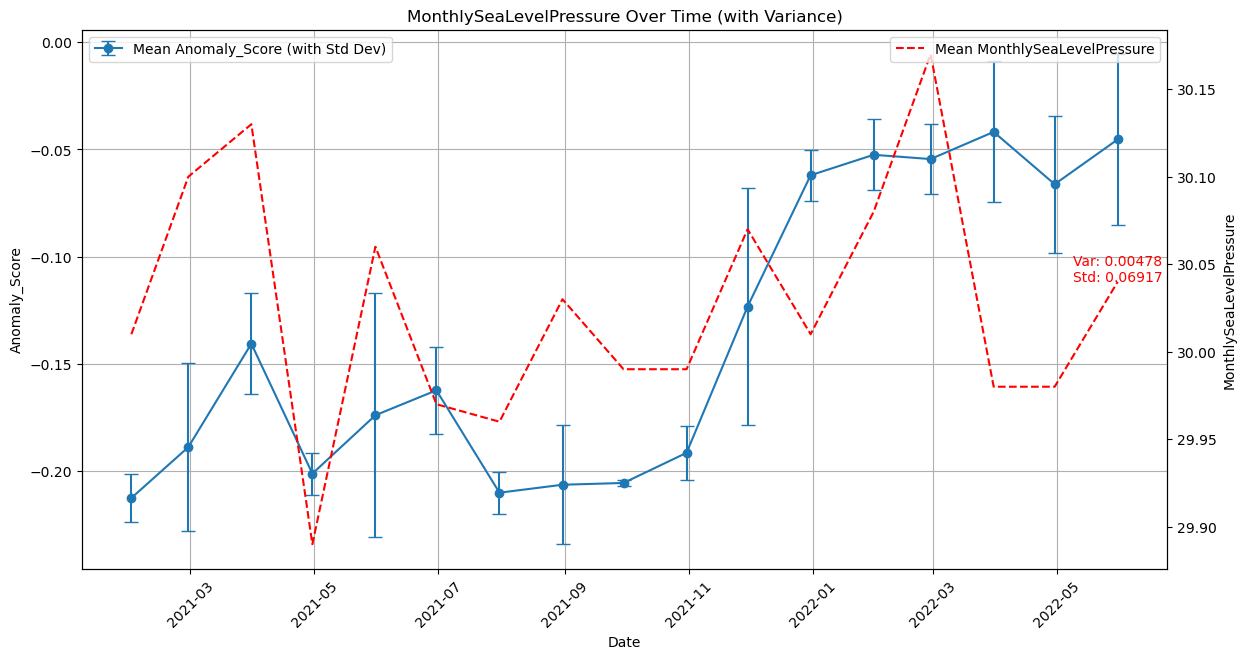

In [180]:
import matplotlib.dates as mdates
def plot_anomaly_and_weather_over_time(data, anomaly_col, weather_col, date_col="DATE"):  
    time_stats = data.groupby(date_col).agg(
        mean_anomaly=(anomaly_col, 'mean'),
        std_anomaly=(anomaly_col, 'std'),
        mean_weather=(weather_col, 'mean')
    ).reset_index()
    
    weather_variance = time_stats['mean_weather'].var()
    weather_std = time_stats['mean_weather'].std()
    weather_mean = time_stats['mean_weather'].mean()

    print(f"Variance in {weather_col}: {weather_variance:.5f}")
    print(f"Standard Deviation in {weather_col}: {weather_std:.5f}")
    print(f"Mean {weather_col}: {weather_mean:.5f}")

    plt.figure(figsize=(14, 7))
    plt.errorbar(
        time_stats[date_col], 
        time_stats['mean_anomaly'], 
        yerr=time_stats['std_anomaly'], 
        fmt='o-', capsize=5, label=f'Mean {anomaly_col} (with Std Dev)'
    )
    plt.title(f'{weather_col} Over Time (with Variance)')
    plt.xlabel('Date')
    plt.ylabel(f'{anomaly_col}')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.grid()
    plt.legend()

    plt.twinx() 
    plt.plot(
        time_stats[date_col], 
        time_stats['mean_weather'], 
        'r--', label=f'Mean {weather_col}'
    )
    plt.ylabel(f'{weather_col}')
    plt.legend(loc='upper right')

    plt.text(
        time_stats[date_col].iloc[-1], 
        time_stats['mean_weather'].iloc[-1], 
        f"Var: {weather_variance:.5f}\nStd: {weather_std:.5f}", 
        color="red", 
        fontsize=10,
        ha='center'
    )

    plt.show()

plot_anomaly_and_weather_over_time(
    data=merged_data,
    anomaly_col="Anomaly_Score",
    weather_col="MonthlyMeanTemperature",
    date_col="DATE"
)

plot_anomaly_and_weather_over_time(
    data=merged_data,
    anomaly_col="Anomaly_Score",
    weather_col="MonthlySeaLevelPressure",
    date_col="DATE"
)

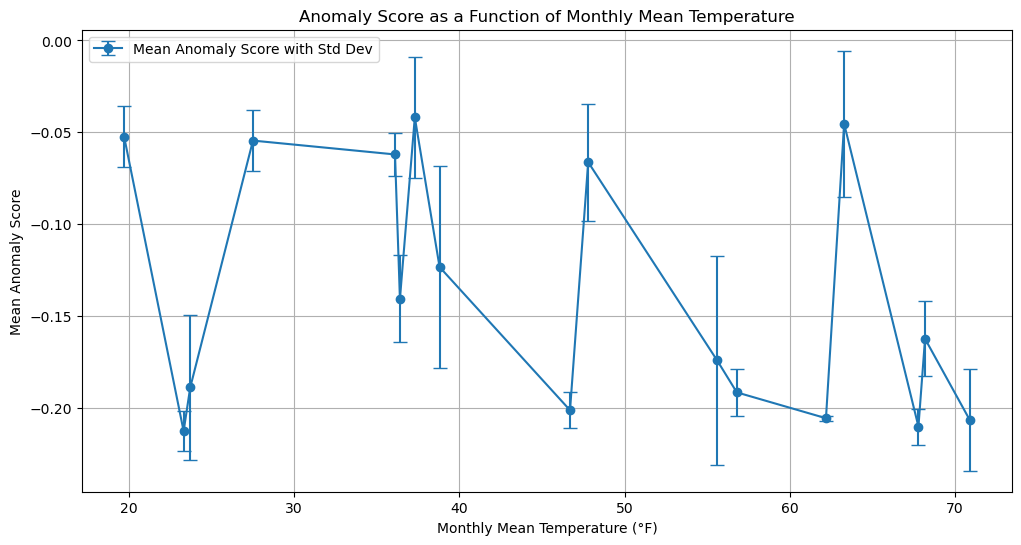

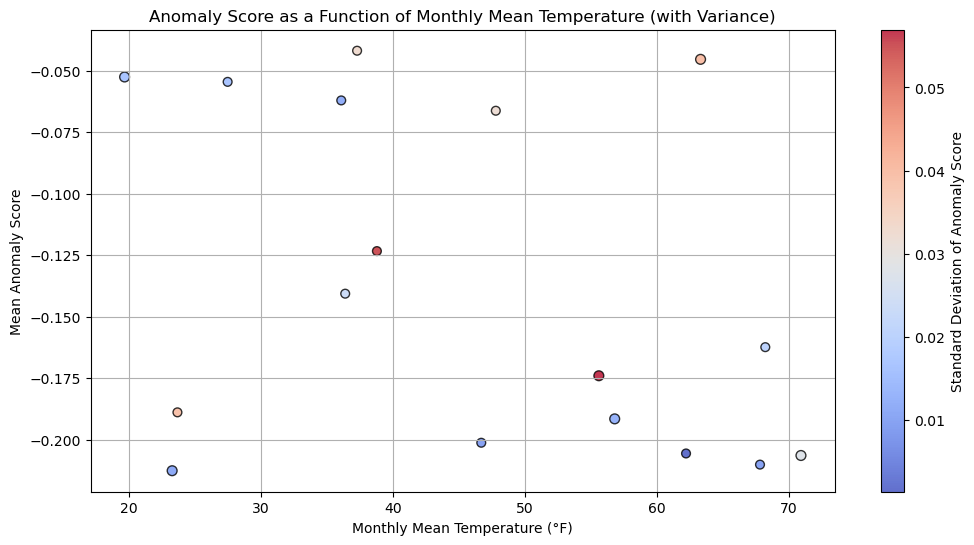

In [173]:
weather_stats = merged_data.groupby('MonthlyMeanTemperature').agg(
    mean_anomaly=('Anomaly_Score', 'mean'),
    std_anomaly=('Anomaly_Score', 'std'),
    count=('Anomaly_Score', 'count')
).reset_index()

plt.figure(figsize=(12, 6))
plt.errorbar(
    weather_stats['MonthlyMeanTemperature'], 
    weather_stats['mean_anomaly'], 
    yerr=weather_stats['std_anomaly'], 
    fmt='o-', capsize=5, label='Mean Anomaly Score with Std Dev'
)
plt.title('Anomaly Score as a Function of Monthly Mean Temperature')
plt.xlabel('Monthly Mean Temperature (°F)')
plt.ylabel('Mean Anomaly Score')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    weather_stats['MonthlyMeanTemperature'], 
    weather_stats['mean_anomaly'], 
    s=weather_stats['count'] * 10,  # Size based on count
    c=weather_stats['std_anomaly'],  # Color based on standard deviation
    cmap='coolwarm', edgecolor='k', alpha=0.8
)
plt.colorbar(scatter, label='Standard Deviation of Anomaly Score')
plt.title('Anomaly Score as a Function of Monthly Mean Temperature (with Variance)')
plt.xlabel('Monthly Mean Temperature (°F)')
plt.ylabel('Mean Anomaly Score')
plt.grid()
plt.show()



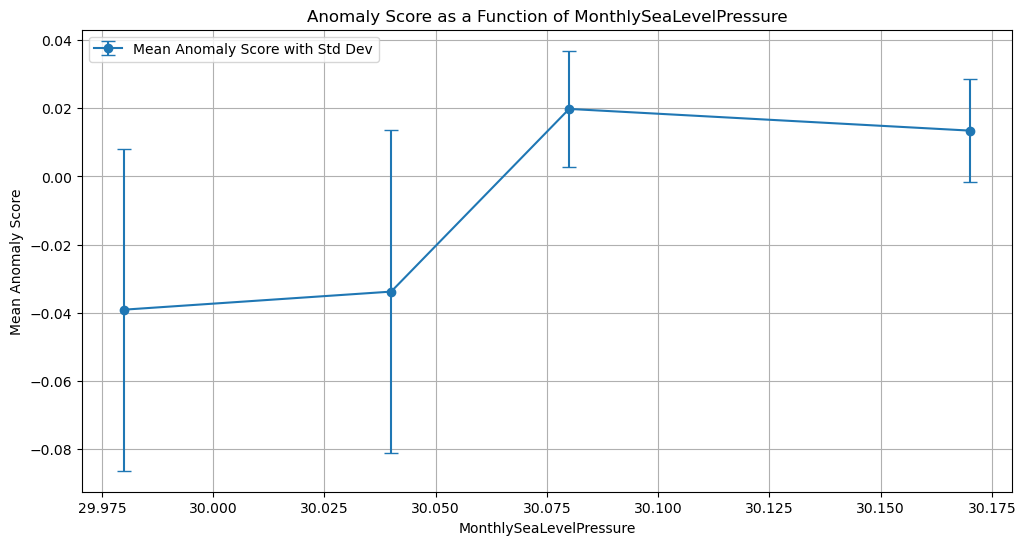

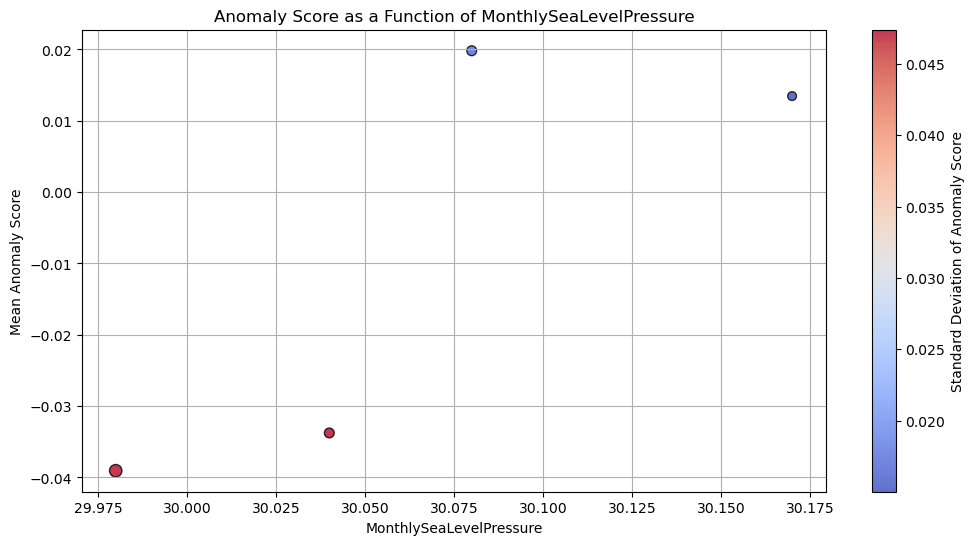

In [166]:
column = 'MonthlySeaLevelPressure'
weather_stats = merged_data.groupby(column).agg(
    mean_anomaly=('Anomaly_Score', 'mean'),
    std_anomaly=('Anomaly_Score', 'std'),
    count=('Anomaly_Score', 'count')
).reset_index()

plt.figure(figsize=(12, 6))
plt.errorbar(
    weather_stats[column], 
    weather_stats['mean_anomaly'], 
    yerr=weather_stats['std_anomaly'], 
    fmt='o-', capsize=5, label='Mean Anomaly Score with Std Dev'
)
plt.title(f'Anomaly Score as a Function of {column}')
plt.xlabel(column)
plt.ylabel('Mean Anomaly Score')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    weather_stats[column], 
    weather_stats['mean_anomaly'], 
    s=weather_stats['count'] * 10,  # Size based on count
    c=weather_stats['std_anomaly'],  # Color based on standard deviation
    cmap='coolwarm', edgecolor='k', alpha=0.8
)
plt.colorbar(scatter, label='Standard Deviation of Anomaly Score')
plt.title(f'Anomaly Score as a Function of {column}')
plt.xlabel(column)
plt.ylabel('Mean Anomaly Score')
plt.grid()
plt.show()